In [1]:
import pyvisa
from nanodrivers.visa_drivers.anapico import ANAPICO
from nanodrivers.visa_drivers.dc import DC
from nanodrivers.visa_drivers.vna import VNA
from nanodrivers.visa_drivers.signal_analyser import Anri
# from nanodrivers.visa_drivers.signal_analizar import Anri

#math
import numpy as np
from numpy import *
from scipy.optimize import curve_fit

#plotting
import matplotlib.pyplot as plt
import matplotlib

#matlab import
import scipy.io
from scipy.io import savemat
from scipy.optimize import minimize

#file_store
import os

#time
import time
from datetime import datetime, timedelta

from ctypes import *
%matplotlib inline

C:\Users\Demag\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
anapico = ANAPICO()
anapico.idn()
anapico.dump()['channel_status']

VisaIOError: VI_ERROR_RSRC_NFOUND (-1073807343): Insufficient location information or the requested device or resource is not present in the system.

In [2]:
dc = DC()
dc.idn()
dc.dump()

Connection exist: HEWLETT-PACKARD,33120A,0,7.0-5.0-1.0



{'device': 'GPIBInstrument at GPIB0::26::INSTR',
 'volt': 0,
 'impedance': '+9.90000E+37\n',
 'shape': 'DC'}

In [4]:
vna = VNA()
vna.idn()
# vna.dump()

Connection exist: Rohde-Schwarz,ZNB20-2Port,1311601062102129,3.45



# 1st tone

In [5]:
vna.set_lin()

folder = r"C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise"
exp_name = 'Long_scan'
path = folder+'\\'+exp_name
if not os.path.exists(path):
  os.mkdir(path)
  print("Folder %s created!" % path)
else:
  print("Folder %s already exists" % path)

Folder C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise\Long_scan already exists


In [52]:
volts = 3.5
vna.set_band(100)
vna.set_nop(30)
vna.set_cw_freq(5.5e9)
vna.set_power(-15)

freqs = np.linspace(10.03, 10.07, 10)*1e9
pows = np.linspace(5.8, 6.5, 10)

state = dict()
state['freqs'] = freqs
state['pows'] = pows

state['volts'] = volts
state['vna'] = vna.dump
state['DC_dev'] = dc.dump
state['anapico'] = anapico.dump()
state['temp'] = 8


mag_1t = np.empty((len(pows),len(freqs)))
pha_1t = np.empty((len(pows),len(freqs)))

state['mag'] = mag_1t
state['mag'] = pha_1t

start_time = datetime.now()
file = r'SSc_{}DC_{}to{}GHz_{}to{}db_'.format(volts, freqs[0]/1e9, freqs[-1]/1e9, pows[0], pows[-1])+ start_time.strftime(r'%H-%M-%S') + '.mat'
file_name = path +'\\' + file

print('Started:', start_time.strftime(r'%H-%M-%S'))

dc.set_volt(volts)
# time.sleep(5)
anapico.set_off(1)
mag_ref, pha_ref = vna.get_data()


anapico.set_on(1)
        

for i in range(len(pows)):
    for j in range(len(freqs)):
    
        anapico.set_freq(1, freqs[j])
        anapico.set_power(1, pows[i])
        
    
        curr_time = datetime.now()
        print('{} -> {}, {}'.format(curr_time.strftime(r'%H:%M:%S'),  i, j), end = '\r')
        
        
        mag, pha = vna.get_data()
        mag_1t[i,j] = np.mean(mag)-np.mean(mag_ref)
        pha_1t[i,j] = np.mean(pha)-np.mean(pha_ref)

        state['mag'] = mag_1t
        state['pha'] = pha_1t

        savemat(file_name, state)

    
# dc.set_volt(0)   
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Started: 22-01-10
Duration: 0:00:56.443338


Text(0.5, 1.0, '$\\angle S_{21} $')

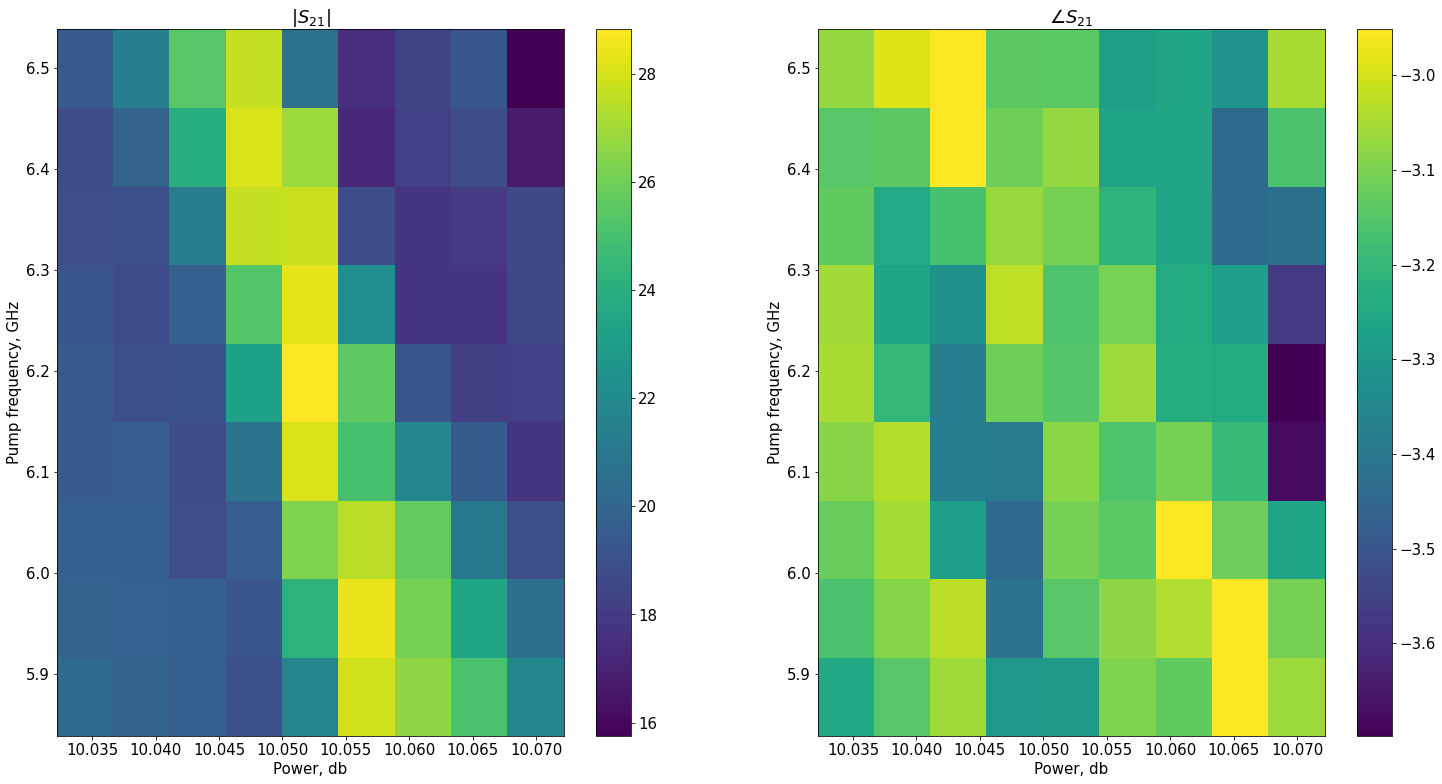

In [53]:
# %matplotlib inline
font = {'size'   : 15}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 2, figsize=(25,13))
c = ax[0].pcolor(freqs[1:]/1e9, pows[1:],  mag_1t[1:,1:], cmap='viridis')
ax[0].set_xlabel(r'Power, db')
ax[0].set_ylabel(r'Pump frequency, GHz')

c1 = ax[1].pcolor(freqs[1:]/1e9, pows[1:],  pha_1t[1:,1:], cmap='viridis')
ax[1].set_xlabel(r'Power, db')
ax[1].set_ylabel(r'Pump frequency, GHz')

fig.colorbar(c, ax=ax[0])
fig.colorbar(c1, ax=ax[1])

ax[0].set_title(r'$|S_{21}|$')
ax[1].set_title(r'$\angle S_{21} $')

In [54]:
anapico.set_off(1)
mag_ref, pha_ref = vna.get_data()

20.108796463928996


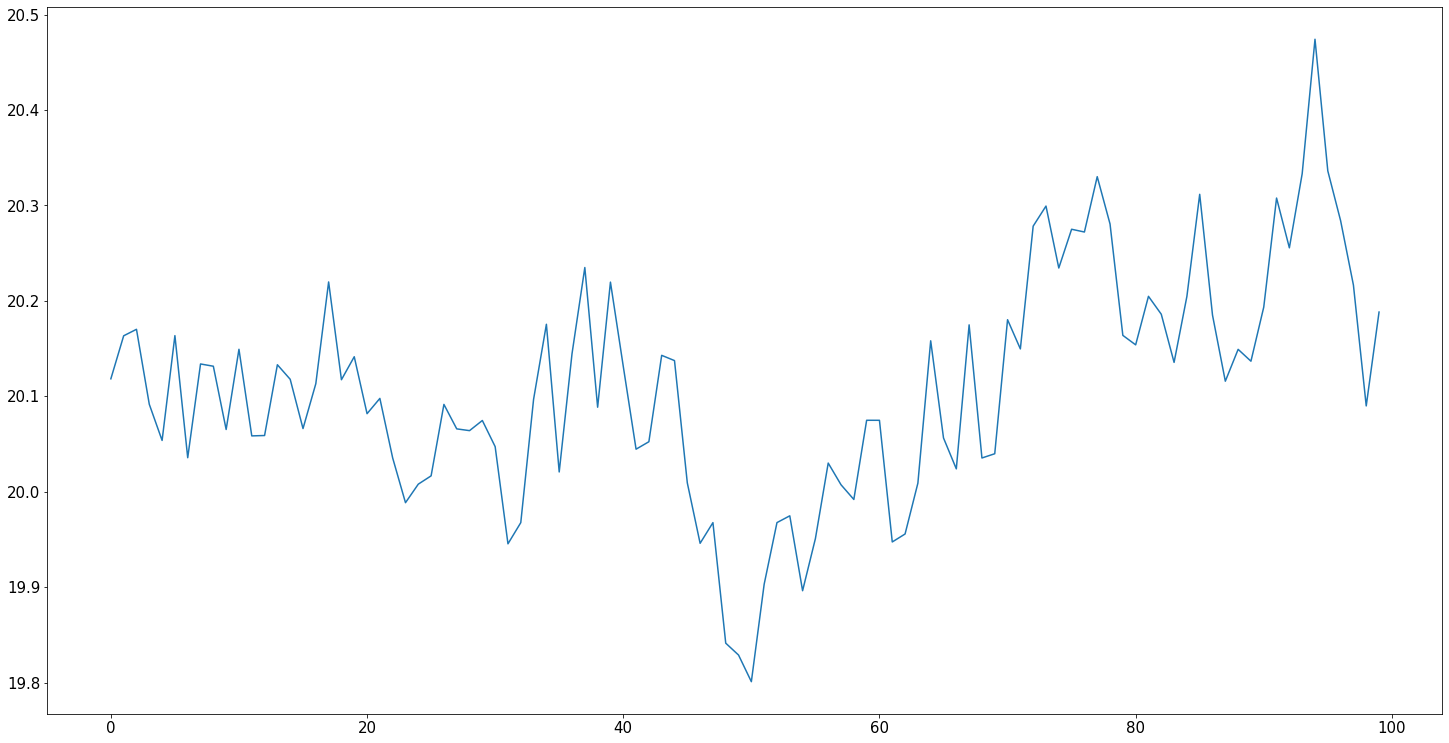

In [65]:
anapico.set_on(1)

anapico.set_freq(1, 10.06e9)
anapico.set_power(1, 6.18)

vna.set_nop(100)
mag, pha = vna.get_data()
print(np.mean(mag)-np.mean(mag_ref))

fig, ax = plt.subplots(figsize=(25,13))
ax.plot(mag-np.mean(mag_ref))

# Points where gain is 20 db

DC = 3 V: 
        freq = 10.7e9
        vna_freq = 5.5e9
        power = 9
        vna_power = -15
        gain = 20.17
        
DC = 3.5 V: 
        freq = 10.06e9
        vna_freq = 5.5e9
        power = 6.18
        vna_power = -15
        gain = 20.17
        
DC = 4 V:         
        freq = 10.69e9
        vna_freq = 5.5e9
        power = 1.8
        vna_power = -15

In [68]:
vna_freq = 5.5e9
vna_power = -15 
vna.set_cw_freq(vna_freq)
vna.set_power(vna_power)

fr_20 = np.array([10.7e9, 10.06e9, 10.69e9])
dc_20 = np.array([3, 3.5, 4])
pow_20 = np.array([9, 6.18, 1.8])

nop = 1000
vna.set_nop(nop)
nomber_of_sweeps = 500

mag_1t = np.empty((len(dc_20),nomber_of_sweeps, nop))
pha_1t = np.empty((len(dc_20),nomber_of_sweeps, nop))

mag_1t_ref = np.empty((len(dc_20),nop))
pha_1t_ref = np.empty((len(dc_20),nop))

state = dict()
state['vna_freq'] = vna_freq
state['vna_power'] = vna_power

state['fr_20'] = fr_20
state['dc_20'] = dc_20
state['pow_20'] = pow_20

state['vna'] = vna.dump
state['DC_dev'] = dc.dump
state['anapico'] = anapico.dump()
state['temp'] = 8

start_time = datetime.now()
file = r'LS_DC{},{}'.format(dc_20[0], dc_20[0])+ start_time.strftime(r'%H-%M-%S') + '.mat'
file_name = path +'\\' + file

start_time = datetime.now()
file_1 = r'LS_DC{},{}_t'.format(dc_20[0], dc_20[0])+ start_time.strftime(r'%H-%M-%S') + '.mat'
file_name_1 = path +'\\' + file_1

print('Started:', start_time.strftime(r'%H-%M-%S'))

for i in range(len(dc_20)):
    
    dc.set_volt(dc_20[i])
    time.sleep(200)
    
    
    anapico.set_off(1)
    mag_1t_ref[i], pha_1t_ref[i] = vna.get_data()
    
    state['mag_ref'] = mag_1t_ref
    state['pha_ref'] = pha_1t_ref
        
    anapico.set_on(1)
    
    anapico.set_freq(1, fr_20[i])
    anapico.set_power(1, pow_20[i])
    
    for j in range(nomber_of_sweeps):
        
        curr_time = datetime.now()
        print('{} -> {}, {}'.format(curr_time.strftime(r'%H:%M:%S'),  i, j), end = '\r')
        
        mag, pha = vna.get_data()
        mag_1t[i,j] = mag
        pha_1t[i,j] = pha
        
        state['mag'] = mag_1t
        state['pha'] = pha_1t
        
        savemat(file_name, state)
        savemat(file_name_1, state)

    
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Started: 22-56-34
Duration: 4:41:37.578937


20.58582420240995 0.07726324655876167
20.172607716449303 0.05982102099715744
20.16578281189993 0.0002707186915512824


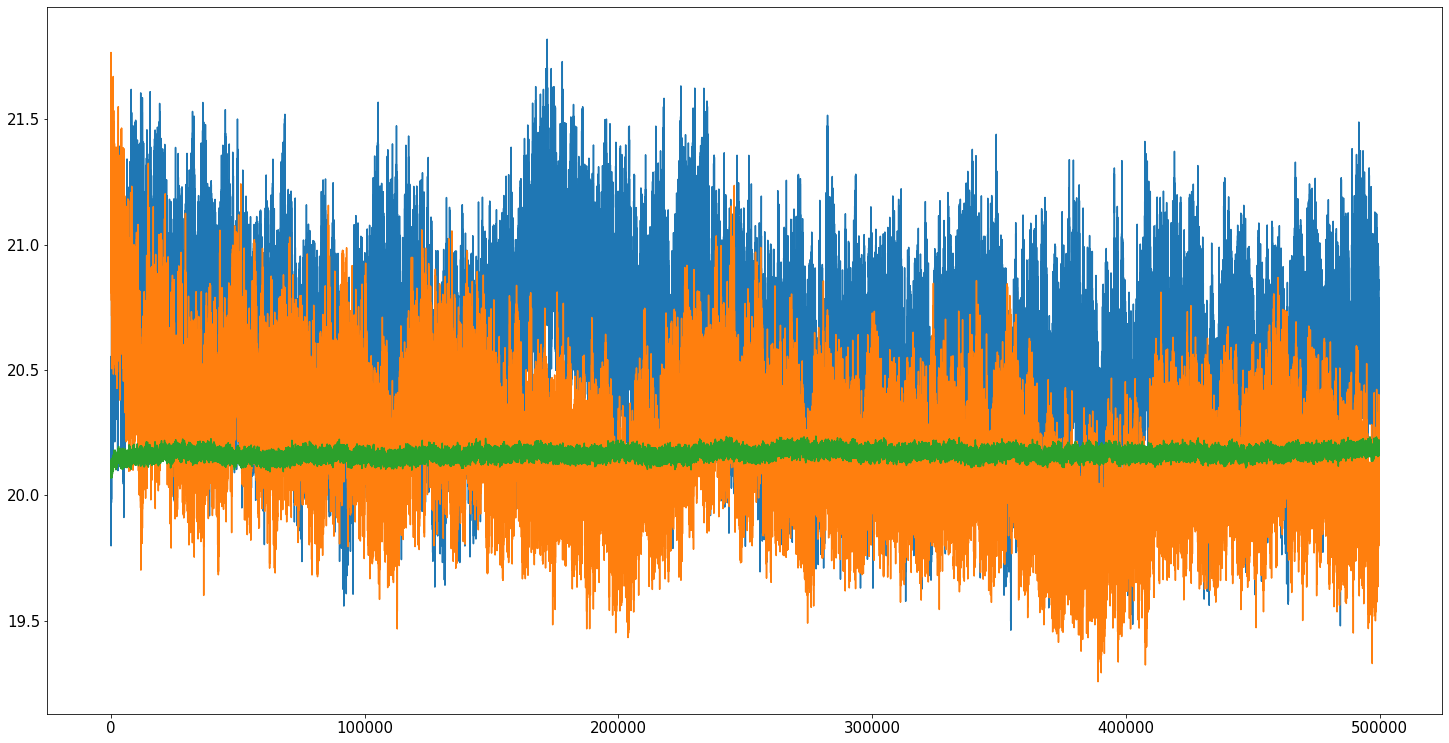

In [72]:
fig, ax = plt.subplots(figsize=(25,13))

for i in range(len(dc_20)):
    m_ref = np.mean(mag_1t_ref[i])
        
    mm = np.concatenate(mag_1t[i])
    print(np.mean(mm[300:]-m_ref), np.var(mm[300:]-m_ref))
    ax.plot(mm[300:]-m_ref)

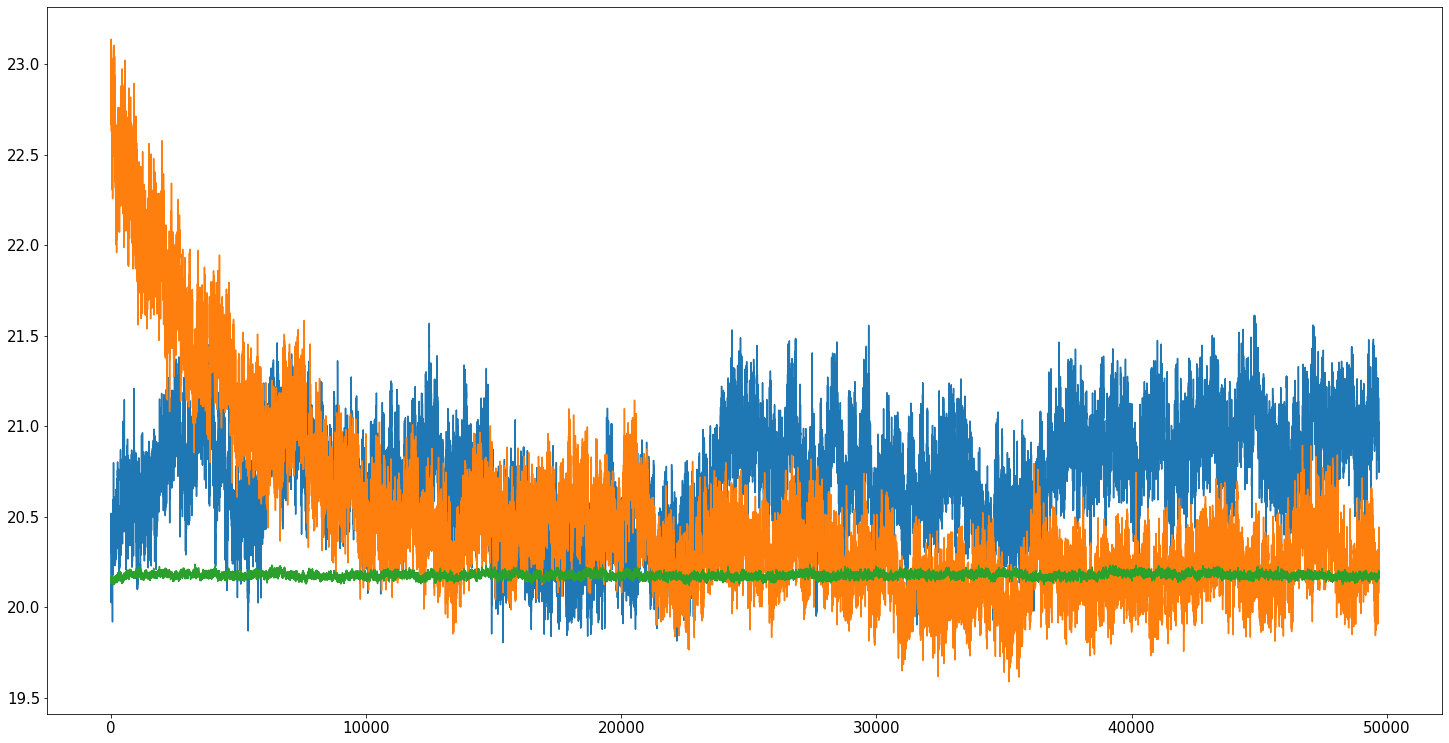

In [67]:
fig, ax = plt.subplots(figsize=(25,13))

for i in range(len(dc_20)):
    m_ref = np.mean(mag_1t_ref[i])
        
    mm = np.concatenate(mag_1t[i])
    
    ax.plot(mm[300:]-m_ref)

# DC fluctuation 

In [84]:
vna_freq = 5.5e9
vna_power = -15 
vna.set_cw_freq(vna_freq)
vna.set_power(vna_power)

dc_20 = np.linspace(1, 5, 20)

nop = 1000
vna.set_nop(nop)
vna.set_band(100)
nomber_of_sweeps = 10

mag_1t = np.empty((len(dc_20),nomber_of_sweeps, nop))
pha_1t = np.empty((len(dc_20),nomber_of_sweeps, nop))


state = dict()
state['vna_freq'] = vna_freq
state['vna_power'] = vna_power

state['fr_20'] = fr_20
state['dc_20'] = dc_20
state['pow_20'] = pow_20

state['vna'] = vna.dump
state['DC_dev'] = dc.dump
state['anapico'] = anapico.dump()
state['temp'] = 8

start_time = datetime.now()
file = r'LS_DC{},{}'.format(dc_20[0], dc_20[-1])+ start_time.strftime(r'%H-%M-%S') + '.mat'
file_name = path +'\\' + file

print('Started:', start_time.strftime(r'%H-%M-%S'))
anapico.set_off(1)

for i in range(len(dc_20)):
    
    dc.set_volt(dc_20[i])
    time.sleep(200)
        
    for j in range(nomber_of_sweeps):
        
        curr_time = datetime.now()
        print('{} -> {}, {}'.format(curr_time.strftime(r'%H:%M:%S'),  i, j), end = '\r')
        
        mag, pha = vna.get_data()
        mag_1t[i,j] = mag
        pha_1t[i,j] = pha
        
        state['mag'] = mag_1t
        state['pha'] = pha_1t
        
        savemat(file_name, state)
    
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Started: 15-57-51
Duration: 1:42:44.110050


-23.688624210219967 0.005148152233530444


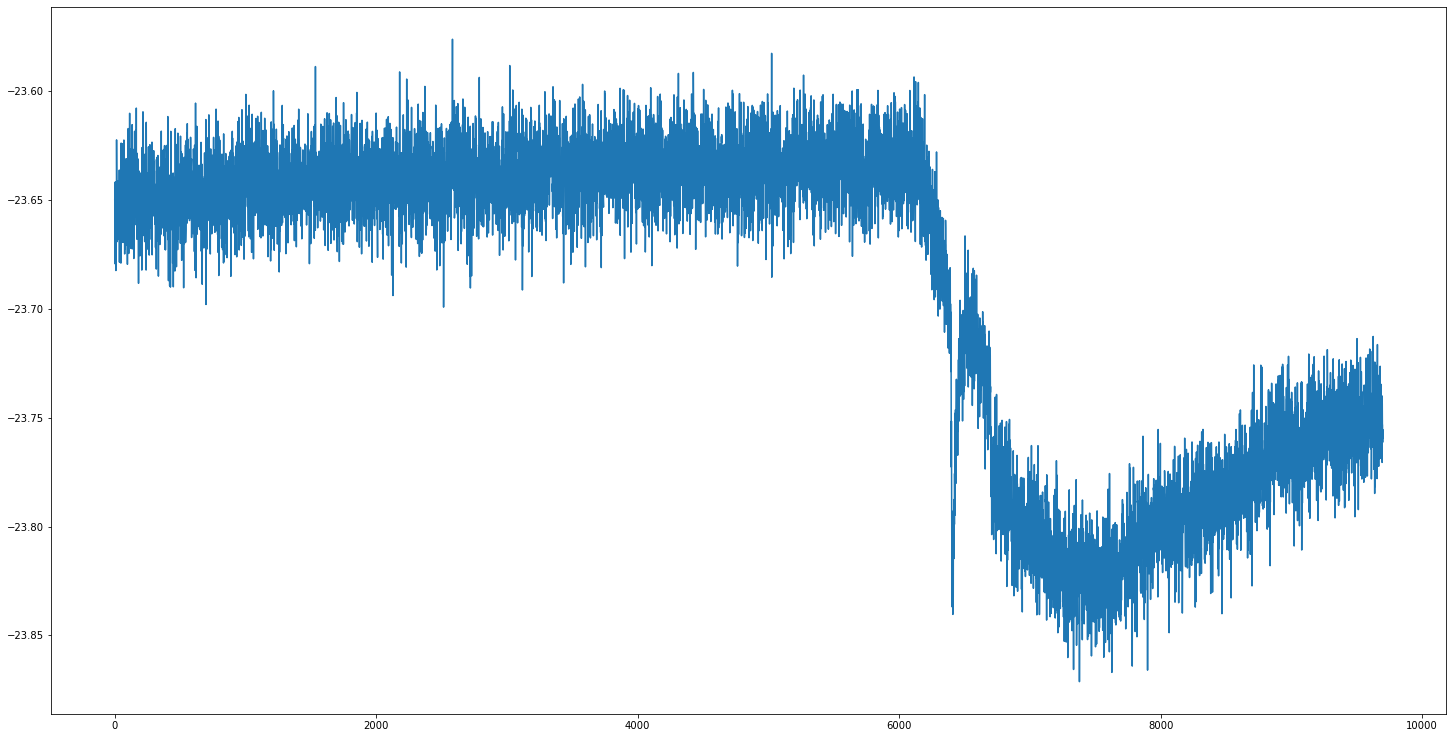

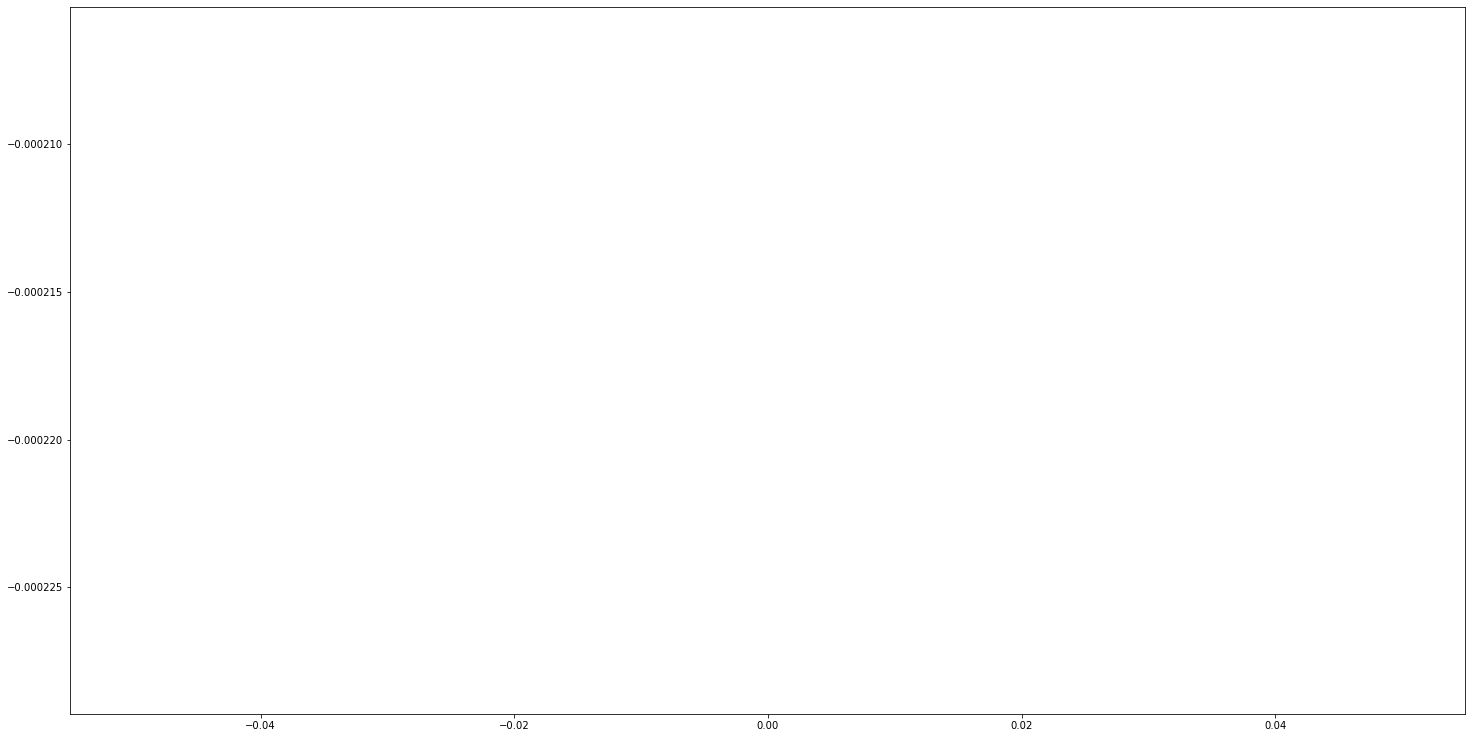

In [95]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(25,13))

vari = np.array([])
mea = np.array([])
for i in [4]:
    ch = 300
    mm = np.concatenate(mag_1t[i])
    print(np.mean(mm[ch:]), np.var(mm[ch:]))
    
    vari = np.append(vari, np.var(mm[ch:]))
    mea = np.append(mea, np.mean(mm[ch:]))
    ax.plot(mm[ch:])
    
fig, ax = plt.subplots(figsize=(25,13))
ax.plot(vari/mea)

# Temperature correlaytion

In [6]:
vna_freq = 5.5e9
vna_power = -15 
vna.set_cw_freq(vna_freq)
vna.set_power(vna_power)

dc_20 = 2

nop = 400
vna.set_nop(nop)
vna.set_band(100)
nomber_of_sweeps = 10000

mag_1t = np.array([])
pha_1t = np.array([])

mag_1t_var = np.array([])
pha_1t_var = np.array([])

time_1t = np.array([])


state = dict()
state['vna_freq'] = vna_freq
state['vna_power'] = vna_power

state['fr_20'] = vna_freq
state['dc_20'] = dc_20

state['vna'] = vna.dump
state['DC_dev'] = dc.dump
state['anapico'] = anapico.dump()
state['temp'] = 8

start_time = datetime.now()
file = r'Temp_scan_DC{}'.format(dc_20)+ start_time.strftime(r'%H-%M-%S') + '.mat'
file_name = path +'\\' + file

print('Started:', start_time.strftime(r'%H-%M-%S'))
anapico.set_off(1)

    
dc.set_volt(dc_20)
# time.sleep(200)

for j in range(nomber_of_sweeps):

    curr_time = datetime.now()
    print('{} -> {}'.format(curr_time.strftime(r'%H:%M:%S'), j), end = '\r')

    mag, pha = vna.get_data()
    
    time_1t = np.append(time_1t, (curr_time - start_time).seconds)
    
    state['time_1t'] = time_1t
    
    mag_1t = np.append(mag_1t, np.mean(mag))
    pha_1t = np.append(pha_1t, np.mean(pha))
    
    mag_1t_var = np.append(mag_1t_var, np.var(mag))
    pha_1t_var = np.append(pha_1t_var, np.var(pha))

    state['mag'] = mag_1t
    state['pha'] = pha_1t
    
    state['mag_var'] = mag_1t_var
    state['pha_var'] = pha_1t_var
    
    savemat(file_name, state)
#     time.sleep(5)
    
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Started: 13-19-11
Duration: 12:21:23.881339


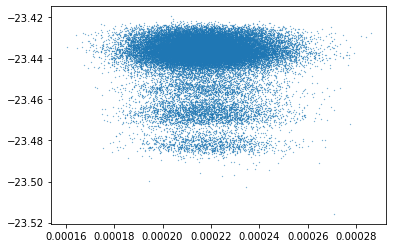

In [115]:
plt.plot(mag_1t_var, mag_1t, '.', markersize = 0.5)

In [128]:
vna_freq = np.linspace(5, 5.1, 100)*1e9
volt = 2
# dc.set_volt(volt)
# time.sleep(10)

vna.set_band(10)
nop = 200
vna.set_nop(nop)

freqs = vna.get_freq()

state = dict()
state['freqs'] = vna_freq
state['volts'] = volt
state['vna'] = vna.dump
state['DC_dev'] = dc.dump
state['anapico'] = anapico.dump()
state['temp'] = 8


mag_1t = np.empty((len(vna_freq),nop))
pha_1t = np.empty((len(vna_freq),nop))

mag_1t_var = np.empty((len(vna_freq)))
pha_1t_var = np.empty((len(vna_freq)))

state['mag'] = mag_1t
state['mag'] = pha_1t

state['mag_var'] = mag_1t_var
state['mag_var'] = pha_1t_var

start_time = datetime.now()
file = r'DC_sweep_with_VAR_{}_'.format(volt)+ start_time.strftime(r'%Y-%m-%d-%H-%M-%S') + '.mat'
file_name = path +'\\' + file

start_time = datetime.now()                  
for i in range(len(vna_freq)):
    
    curr_time = datetime.now()
    print('{} -> {}'.format(i, curr_time.strftime(r'%H:%M:%S')))
    vna.set_cw_freq(vna_freq[i])
                  
    mag_1t[i], pha_1t[i] = vna.get_data()
    
    mag_1t_var[i] = np.var(mag_1t[i])
    pha_1t_var[i] = np.var(pha_1t[i])
    
    state['mag'] = mag_1t
    state['mag'] = pha_1t
    
    state['mag_var'] = mag_1t_var
    state['mag_var'] = pha_1t_var
    
    savemat(file_name, state)
    
    
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

0 -> 19:21:26
1 -> 19:21:46
2 -> 19:22:07
3 -> 19:22:28
4 -> 19:22:49
5 -> 19:23:09
6 -> 19:23:30
7 -> 19:23:51
8 -> 19:24:11
9 -> 19:24:32
10 -> 19:24:53
11 -> 19:25:13
12 -> 19:25:34
13 -> 19:25:55
14 -> 19:26:15
15 -> 19:26:36
16 -> 19:26:57
17 -> 19:27:18
18 -> 19:27:38
19 -> 19:27:59
20 -> 19:28:20
21 -> 19:28:40
22 -> 19:29:01
23 -> 19:29:22
24 -> 19:29:42
25 -> 19:30:03
26 -> 19:30:24
27 -> 19:30:45
28 -> 19:31:05
29 -> 19:31:26
30 -> 19:31:47
31 -> 19:32:07
32 -> 19:32:28
33 -> 19:32:49
34 -> 19:33:09
35 -> 19:33:30
36 -> 19:33:51
37 -> 19:34:12
38 -> 19:34:32
39 -> 19:34:53
40 -> 19:35:14
41 -> 19:35:34
42 -> 19:35:55
43 -> 19:36:16
44 -> 19:36:36
45 -> 19:36:57
46 -> 19:37:18
47 -> 19:37:38
48 -> 19:37:59
49 -> 19:38:20
50 -> 19:38:41
51 -> 19:39:01
52 -> 19:39:22
53 -> 19:39:43
54 -> 19:40:03
55 -> 19:40:24
56 -> 19:40:45
57 -> 19:41:05
58 -> 19:41:26
59 -> 19:41:47
60 -> 19:42:08
61 -> 19:42:28
62 -> 19:42:49
63 -> 19:43:09
64 -> 19:43:29
65 -> 19:43:50
66 -> 19:44:11
67 ->

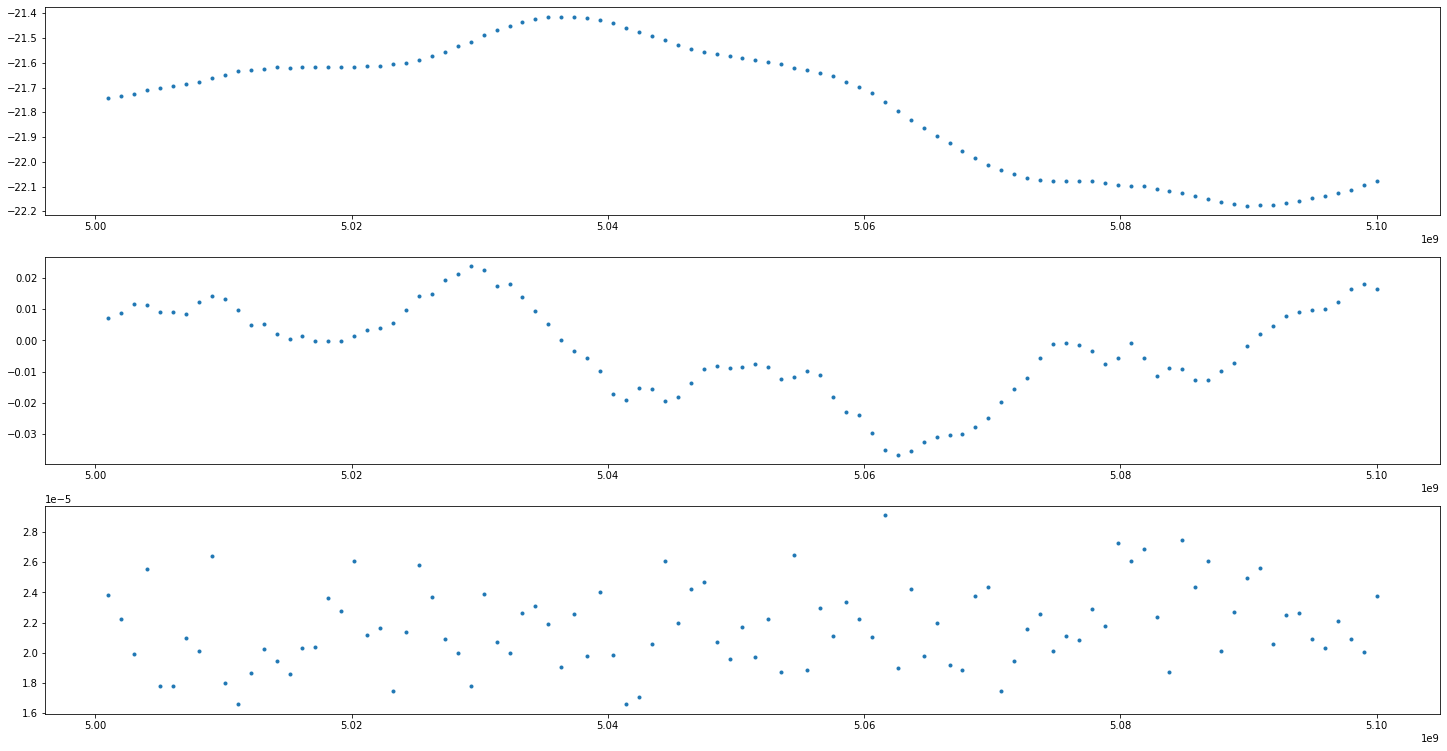

In [140]:
fig, ax = plt.subplots(3, 1, figsize=(25,13))
ax[0].plot(vna_freq[1:], np.mean(mag_1t[1:],axis=1), '.')
ax[1].plot(vna_freq[1:], np.gradient(np.mean(mag_1t[1:],axis=1)), '.')
ax[2].plot(vna_freq[1:], mag_1t_var[1:], '.')

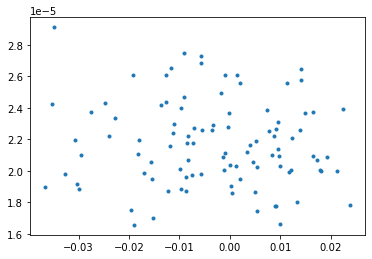

In [142]:
plt.plot(np.gradient(np.mean(mag_1t[1:],axis=1)), mag_1t_var[1:], '.')

In [144]:
corr_coef = np.corrcoef(np.gradient(np.mean(mag_1t[1:],axis=1)), mag_1t_var[1:])
corr_coef

array([[ 1.        , -0.08551284],
       [-0.08551284,  1.        ]])

In [148]:
corr_coef = np.corrcoef(np.mean(mag_1t[1:],axis=1), mag_1t_var[1:])
corr_coef

array([[ 1.        , -0.20768275],
       [-0.20768275,  1.        ]])

# DC sweep for single freq. 

In [25]:
vna_freq = 5.5e9
vna.set_cw_freq(vna_freq)
volt = np.linspace(2.5, 2.7, 10)


vna.set_band(100)
nop = 10000
vna.set_nop(nop)


state = dict()
state['freqs'] = vna_freq
state['volts'] = volt
state['vna'] = vna.dump()
state['DC_dev'] = dc.dump()
state['anapico'] = anapico.dump()
state['temp'] = 8


mag_1t = np.empty((len(volt),nop))
pha_1t = np.empty((len(volt),nop))

mag_1t_var = np.empty((len(volt)))
pha_1t_var = np.empty((len(volt)))

state['mag'] = mag_1t
state['mag'] = pha_1t

state['mag_var'] = mag_1t_var
state['mag_var'] = pha_1t_var

start_time = datetime.now()
file = r'DC_sweep_with_VAR'+ start_time.strftime(r'%Y-%m-%d-%H-%M-%S') + '.mat'
file_name = path +'\\' + file

start_time = datetime.now()                  
for i in range(len(volt)):
    
    curr_time = datetime.now()
    print('{} -> {}'.format(i, curr_time.strftime(r'%H:%M:%S')), end = '\r')
    
    dc.set_volt(volt[i])
    time.sleep(100)
    
                      
    mag_1t[i], pha_1t[i] = vna.get_data()
    
    mag_1t_var[i] = np.var(mag_1t[i])
    pha_1t_var[i] = np.var(pha_1t[i])
    
    state['mag'] = mag_1t
    state['mag'] = pha_1t
    
    state['mag_var'] = mag_1t_var
    state['mag_var'] = pha_1t_var
    
    savemat(file_name, state)
    
    
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:34:21.134841


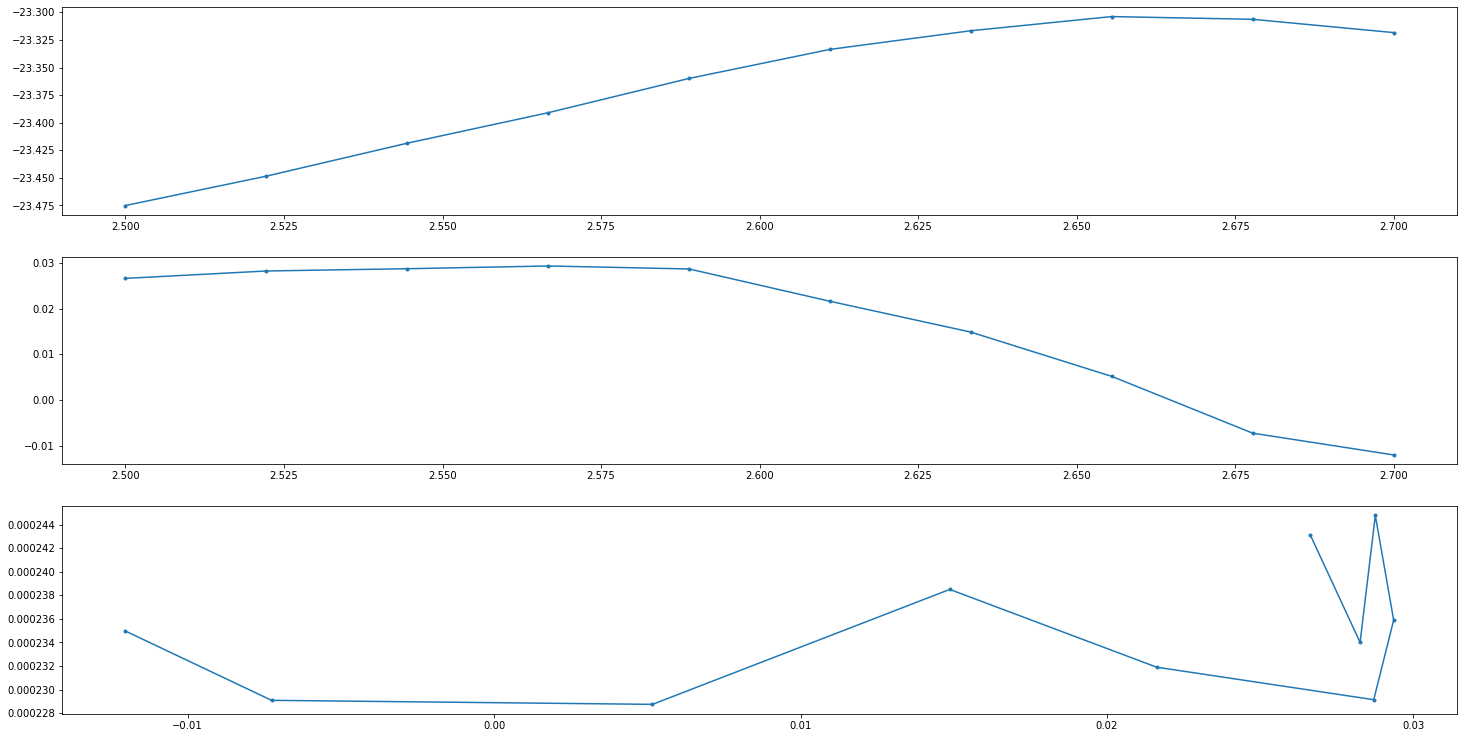

In [33]:
fig, ax = plt.subplots(3, 1, figsize=(25,13))
ax[0].plot(volt, np.mean(mag_1t,axis=1), '.-')
ax[1].plot(volt, np.gradient(np.mean(mag_1t,axis=1)), '.-')
ax[2].plot(np.gradient(np.mean(mag_1t,axis=1)), mag_1t_var, '.-')

In [31]:
corr_coef = np.corrcoef(np.gradient(np.mean(mag_1t,axis=1)), mag_1t_var)
corr_coef

array([[1.      , 0.395964],
       [0.395964, 1.      ]])

In [64]:
vna_freq = 5.5e9
vna.set_cw_freq(vna_freq)
volt = np.linspace(0, 5, 100)


vna.set_band(100)
nop = 10000
vna.set_nop(nop)


state = dict()
state['freqs'] = vna_freq
state['volts'] = volt
state['vna'] = vna.dump()
state['DC_dev'] = dc.dump()
state['anapico'] = anapico.dump()
state['temp'] = 8


mag_3t = np.empty((len(volt),nop))
pha_3t = np.empty((len(volt),nop))

mag_3t_var = np.empty((len(volt)))
pha_3t_var = np.empty((len(volt)))

state['mag'] = mag_3t
state['mag'] = pha_3t

state['mag_var'] = mag_3t_var
state['mag_var'] = pha_3t_var

start_time = datetime.now()
file = r'DC_sweep_with_VAR'+ start_time.strftime(r'%Y-%m-%d-%H-%M-%S') + '.mat'
file_name = path +'\\' + file

start_time = datetime.now()                  
for i in range(len(volt)):
    
    curr_time = datetime.now()
    print('{} -> {}'.format(i, curr_time.strftime(r'%H:%M:%S')), end = '\r')
    
    dc.set_volt(volt[i])
    time.sleep(100)
    
                      
    mag_3t[i], pha_3t[i] = vna.get_data()
    
    mag_3t_var[i] = np.var(mag_3t[i])
    pha_3t_var[i] = np.var(pha_3t[i])
    
    state['mag'] = mag_3t
    state['mag'] = pha_3t
    
    state['mag_var'] = mag_3t_var
    state['mag_var'] = pha_3t_var
    
    savemat(file_name, state)
    
    
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

KeyboardInterrupt: 

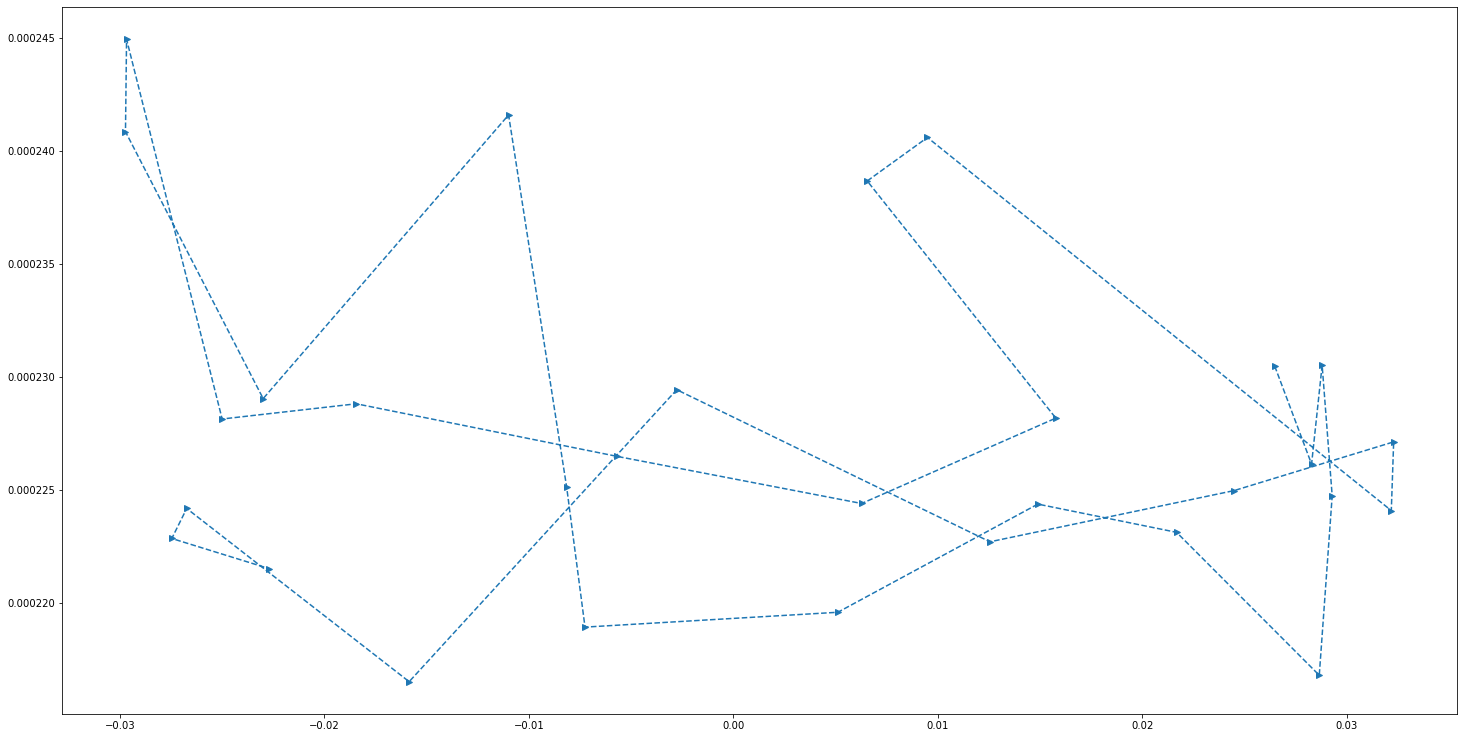

In [62]:
mag = np.array([])
mag = np.append(np.mean(mag_1t[:,500:],axis=1), np.mean(mag_2t[:,500:],axis=1))
mag = np.append(mag, np.mean(mag_3t[:,500:],axis=1))


mag_var = np.array([])

var1 = np.array([])
var2 = np.array([])
var3 = np.array([])
for i in range(10):
    var1 =  np.append(var1, np.var(mag_1t[i, 500:]))
    var2 =  np.append(var2, np.var(mag_2t[i, 500:]))
    var3 =  np.append(var3, np.var(mag_3t[i, 500:]))
    
mag_var = np.append(var1,var2)
mag_var = np.append(mag_var,var3)


volts = np.linspace(2.5, 3.1, 30)


fig, ax = plt.subplots(1, 1, figsize=(25,13))
# ax[0].plot(volts, mag, '.-')
# ax[1].plot(volts, np.gradient(mag), '.-')
ax.plot( np.gradient(mag), mag_var, '>--')

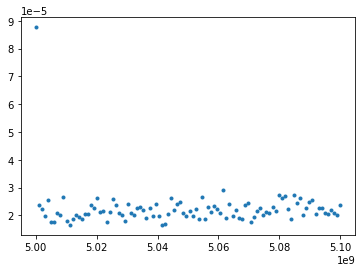

In [134]:
plt.plot(vna_freq, mag_1t_var, '.')

In [128]:
vna.set_lin()
vna.set_stop_freq(8e9)
vna.set_nop(2000)
vna.set_band(100)
freq = vna.get_freq()
mag, pha = vna.get_data()

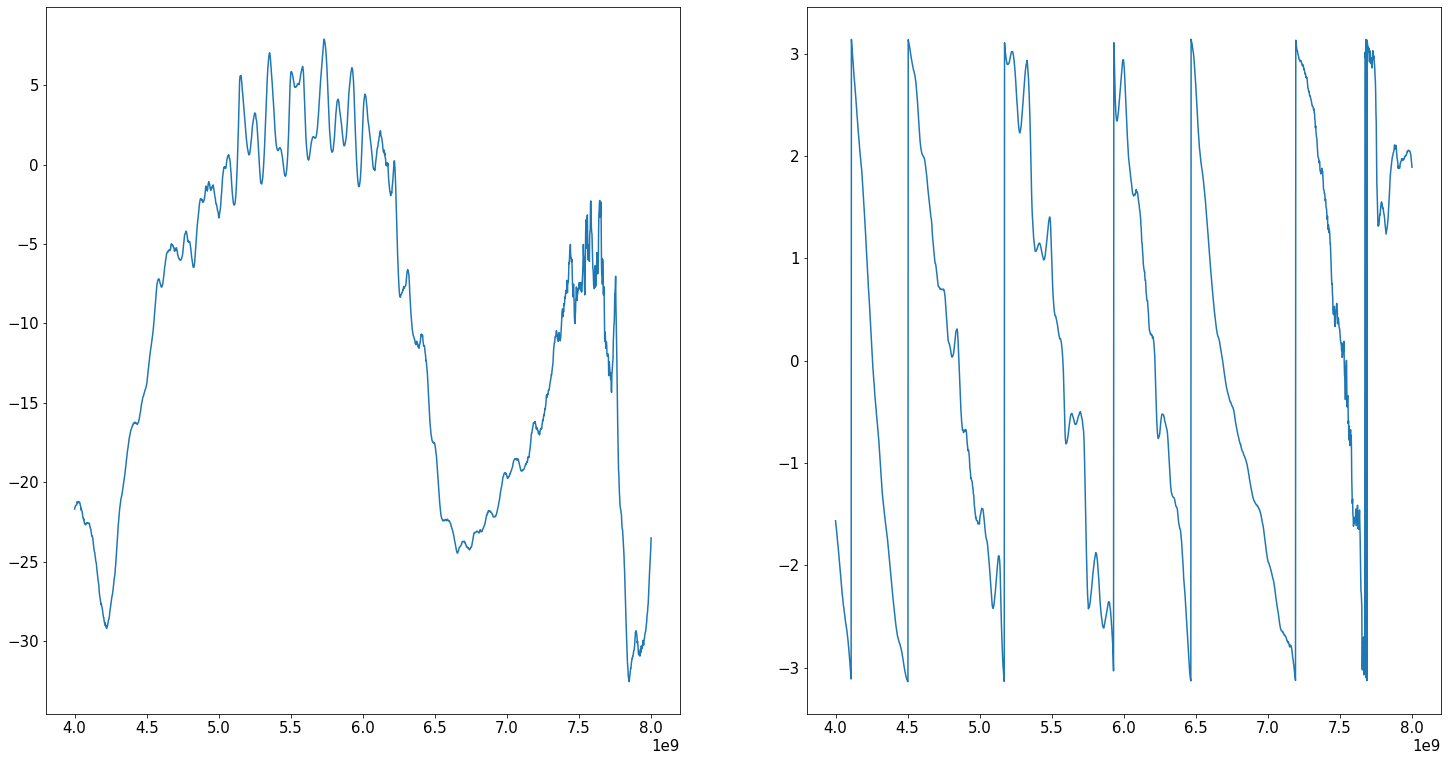

In [129]:
fig, ax = plt.subplots(1, 2, figsize=(25,13))
ax[0].plot(freq, mag)
ax[1].plot(freq, pha)

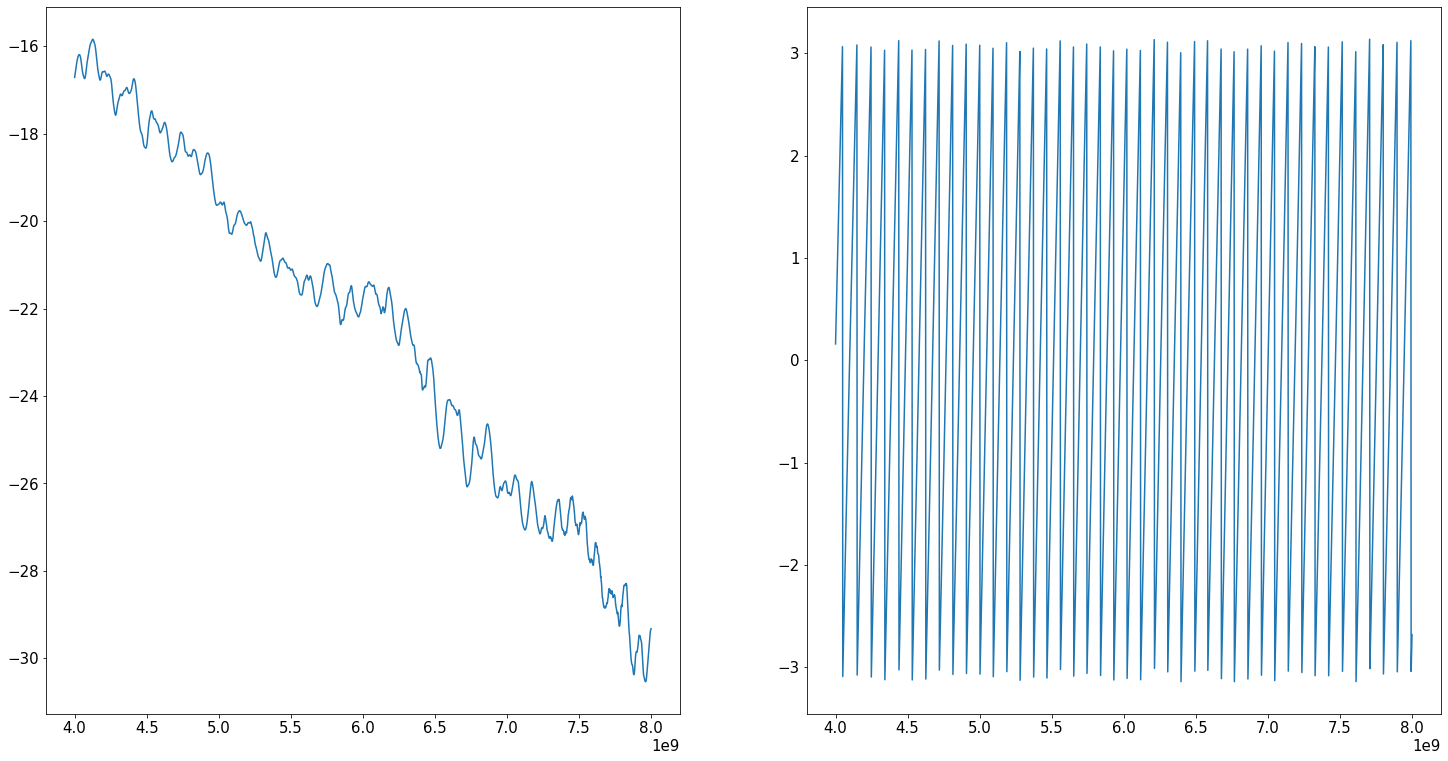

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(25,13))
ax[0].plot(freq, mag)
ax[1].plot(freq, pha)